# Import Libs

In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocessing

Define mark which will  set min mark limit

In [384]:
data = pd.read_excel('dataset_norm.xlsx')
data.dropna

min_mark = 4

In [385]:
def print_losers():
    for j in range(len(data.index)):
        if data['Средний балл'][j] < 4:
            print(data['Учащийся'][j])

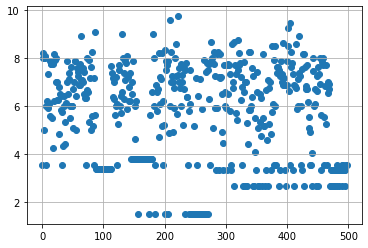

In [386]:
x = range(len(data['Средний балл']))
y = data['Средний балл']

plt.scatter(x, y)
plt.grid()
plt.show()

In [387]:
# Replase mark of student by belonging to the class of successfully passed
data['Сдал'] = pd.cut(x=data['Средний балл'], bins=[0, min_mark, 10], labels=[0, 1])
data.drop(['Средний балл'], axis = 1, inplace= True)

# Drop indicators which are not connected with extracurricular activities
data_raw_copy = data
data.drop([ 'Учащийся',
            'Дата прохождения теста',
            '15.Образование Ваших родителей?', 
            '3.С какими оценками Вы закончили школу?',
            '4.Ходили ли Вы на подготовительные курсы перед поступлением в вуз?',
            '7.Какая у Вас семья?',
            '10.Получали ли Вы стипендию? (в течение последнего года)',
            '11.Оцените, как Вам нравится учиться?',
            '13.На какие средства Вы живете?',
            '5.Брали ли Вы академический отпуск?',
            '17.Укажите Ваше семейное положение.',
            '12.Каковы условия Вашего проживания?'
            ],
            axis = 1, inplace = True)
            
data.head()

,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
0,Нет,"да, хожу на фитнес или в тренажерный зал",От 1 до 3 часов в день,Среднее количество пропусков,1-2 раза в семестр,нет,Нет,0
1,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,"Нет, но собираюсь в этом году",1
2,Да,"нет, не занимаюсь",Готовлюсь только перед занятиями,Регулярно пропускаете,Всегда,нет,Нет,1
3,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,Нет,1
4,Нет,"да, занимаюсь шахматами/шашками;нет, не занимаюсь",Более 3 часов в день,Среднее количество пропусков,1-2 раза в год,нет,Да,1


Lets find out how many students did not pass the exams

In [360]:
def counter_print():
    passed = 0
    not_passed = 0
    res = 0
    for i in data['Сдал']:
        if i == 1:
            passed += 1
        elif i == 0:
            not_passed += 1
        res += 1
    print(f"TOTAL: {res}\nPassed: {passed}\nNot pas: {not_passed}")

counter_print()


TOTAL: 498
Passed: 341
Not pas: 157


Split our data in 3 parts for train, test and validation

In [361]:
def train_test_val_split(test_ratio, validation_ratio):
    label_encoder = LabelEncoder()

    s = (data.dtypes == 'object')
    object_cols = list(s[s].index)
    label_data = data.copy()
    for col in object_cols:
        label_encoder.fit(data[col])
        label_data[col] = label_encoder.transform(data[col])

    
    size = data.shape[0]
    validation_ratio = (validation_ratio * size) / (size * (1 - test_ratio))
    X_train, X_test, y_train, y_test = train_test_split(label_data.drop('Сдал', axis = 1), 
                                                        label_data['Сдал'], 
                                                        test_size=test_ratio,
                                                        random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(  X_train,
                                                        y_train, 
                                                        test_size=validation_ratio, 
                                                        random_state=1)

    return X_train, X_test, X_val, y_train, y_test, y_val

In [362]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(test_ratio=0.25, validation_ratio=0.01)


In [388]:
X_train

,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?
104,1,1,8,2,2,7,1
55,1,16,1,0,3,7,0
30,1,14,1,0,0,7,0
365,1,14,9,2,0,1,0
113,1,14,8,0,3,0,1
...,...,...,...,...,...,...,...
217,1,14,3,0,3,4,1
77,1,14,3,0,3,7,1
261,1,20,8,2,0,7,1
202,1,14,3,2,3,7,1


# Model variants
In that part I will choose the classification model which will predict if student pass exams successfully or not

## Metrics Functions

In [364]:
def classification_quality(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("F1:", f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
    print("Weighted Recall:", (precision_recall_fscore_support(y_test, y_pred, average='macro')))

In [365]:
def regression_quality(y_test, y_pred):
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred)**(1/2))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2:", r2_score(y_test, y_pred))

In [366]:
metrics_list = ['Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1', 'MSE', 'RMSE', 'MAE', 'R2']
model_array = []
output_array = []

def compilance_print(model, y_test, y_pred, model_flag):
    temp_array = []
    if model_flag == 'cls': # classifier
        temp_array.append(accuracy_score(y_test, y_pred))
        temp_array.append(balanced_accuracy_score(y_test, y_pred))
        temp_array.append(recall_score(y_test, y_pred, average='macro'))
        temp_array.append(precision_score(y_test, y_pred, average='macro'))
        temp_array.append(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        for i in range(4): temp_array.append(None)
    elif model_flag == 'reg': # regression
        for i in range(5): temp_array.append(None)
        temp_array.append(mean_squared_error(y_test, y_pred))
        temp_array.append(mean_squared_error(y_test, y_pred)**(1/2))
        temp_array.append(mean_absolute_error(y_test, y_pred))
        temp_array.append(r2_score(y_test, y_pred))
    else: 
        print('Error')
        for i in range(len(metrics_list)): temp_array.append(None)

    model_indx = -1
    flag = 1
    for indx, _model in enumerate(model_array):
        if _model == model:
            model_indx = indx
            flag = 0
    if flag:
        output_array.append([0]* len(metrics_list))
        model_indx = len(model_array)
        model_array.append(model)
    for indx, el in enumerate(temp_array):
        output_array[model_indx][indx] = el

In [367]:
def graph_show(model, X_test, y_test):
    metrics.plot_confusion_matrix(model, X_test, y_test) 
    metrics.plot_roc_curve(model, X_test, y_test)
    plt.show()

## Classifier

### Perception Classifier Model

In [368]:
from sklearn.linear_model import Perceptron
Perc = Perceptron()
Perc.fit(X_train, y_train)

y_pred = Perc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('Perceptron', y_test, y_pred, 'cls')


Accuracy: 0.792
Recall: 0.6956388206388207
Precision: 0.7715260017050298
F1: 0.7149122807017544
Weighted Recall: (0.7715260017050298, 0.6956388206388207, 0.7149122807017544, None)


### Random Forest Classifier Model

In [369]:
from sklearn.ensemble import RandomForestClassifier
RanF = RandomForestClassifier()
RanF.fit(X_train, y_train)

y_pred = RanF.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('RandomForest', y_test, y_pred, 'cls')


Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0
Weighted Recall: (1.0, 1.0, 1.0, None)


### Gradient Boosting Classifier Model

In [370]:
from sklearn.ensemble import GradientBoostingClassifier
GraB = GradientBoostingClassifier()
GraB.fit(X_train, y_train)

y_pred = GraB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GradientBoosting', y_test, y_pred, 'cls')

Accuracy: 0.992
Recall: 0.9943181818181819
Precision: 0.986842105263158
F1: 0.9904761904761904
Weighted Recall: (0.986842105263158, 0.9943181818181819, 0.9904761904761904, None)


### MultinomialNB Classifier Model

In [371]:
from sklearn.naive_bayes import MultinomialNB
MulNB = MultinomialNB()
MulNB.fit(X_train, y_train)

y_pred = MulNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MultinomialNB', y_test, y_pred, 'cls')

Accuracy: 0.776
Recall: 0.817414004914005
Precision: 0.7654083204930663
F1: 0.7632575757575757
Weighted Recall: (0.7654083204930663, 0.817414004914005, 0.7632575757575757, None)


### ComplementNB Classifier Model

In [372]:
from sklearn.naive_bayes import ComplementNB
ComNB = ComplementNB()
ComNB.fit(X_train, y_train)

y_pred = ComNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('ComplementNB', y_test, y_pred, 'cls')

Accuracy: 0.792
Recall: 0.8522727272727273
Precision: 0.7936507936507937
F1: 0.7833333333333333
Weighted Recall: (0.7936507936507937, 0.8522727272727273, 0.7833333333333333, None)


### GaussianNB Classifier Model

In [373]:
from sklearn.naive_bayes import GaussianNB
GaNB = GaussianNB()
GaNB.fit(X_train, y_train)

y_pred = GaNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GaussianNB', y_test, y_pred, 'cls')

Accuracy: 0.92
Recall: 0.9431818181818181
Precision: 0.8936170212765957
F1: 0.9103557085484797
Weighted Recall: (0.8936170212765957, 0.9431818181818181, 0.9103557085484797, None)


### BernoulliNB Classifier Model

In [374]:
from sklearn.naive_bayes import BernoulliNB
BerNB = BernoulliNB()
BerNB.fit(X_train, y_train)

y_pred = BerNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('BernoulliNB', y_test, y_pred, 'cls')

Accuracy: 0.888
Recall: 0.9204545454545454
Precision: 0.8627450980392157
F1: 0.8772446689113356
Weighted Recall: (0.8627450980392157, 0.9204545454545454, 0.8772446689113356, None)


### SVC Classifier Model

In [375]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('SVC', y_test, y_pred, 'cls')

Accuracy: 0.936
Recall: 0.9545454545454546
Precision: 0.9111111111111111
F1: 0.9274099883855982
Weighted Recall: (0.9111111111111111, 0.9545454545454546, 0.9274099883855982, None)


### LinearSVC Classifier Model

In [376]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('LinearSVC', y_test, y_pred, 'cls')

Accuracy: 0.912
Recall: 0.914004914004914
Precision: 0.8866896156052783
F1: 0.8982160041453845
Weighted Recall: (0.8866896156052783, 0.914004914004914, 0.8982160041453845, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### OneClassSVM Classifier Model

In [377]:
from sklearn.svm import OneClassSVM
oclsvc = OneClassSVM()
oclsvc.fit(X_train, y_train)

y_pred = oclsvc.predict(X_test)

classification_quality(y_test, y_pred)
#compilance_print('OneClassSVM', y_test, y_pred, 'cls')

Accuracy: 0.192
Recall: 0.0909090909090909
Precision: 0.17391304347826086
F1: 0.1791044776119403
Weighted Recall: (0.17391304347826086, 0.0909090909090909, 0.11940298507462686, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/py

### DecisionTreeClassifier Model

In [378]:
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('DecisionTreeClassifier', y_test, y_pred, 'cls')

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0
Weighted Recall: (1.0, 1.0, 1.0, None)


### ExtraTreeClassifier Model

In [379]:
from sklearn.tree import plot_tree, ExtraTreeClassifier
extr = ExtraTreeClassifier()
extr.fit(X_train, y_train)

y_pred = extr.predict(X_test)

#plot_tree(extr)
classification_quality(y_test, y_pred)
compilance_print('ExtraTreeClassifier', y_test, y_pred, 'cls')

Accuracy: 0.984
Recall: 0.9886363636363636
Precision: 0.9743589743589743
F1: 0.9810949788263763
Weighted Recall: (0.9743589743589743, 0.9886363636363636, 0.9810949788263763, None)


### MLPClassifier Model

In [380]:
from sklearn.neural_network import MLPClassifier
MLPCl = MLPClassifier()
MLPCl.fit(X_train, y_train)

y_pred = MLPCl.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MLPClassifier', y_test, y_pred, 'cls')

Accuracy: 0.944
Recall: 0.9602272727272727
Precision: 0.9204545454545454
F1: 0.9360800642851925
Weighted Recall: (0.9204545454545454, 0.9602272727272727, 0.9360800642851925, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Matrix
That table helps to understand which model is better for my work

In [381]:
pd.DataFrame(index=metrics_list, columns=model_array, data=np.array(pd.DataFrame(output_array).T))

,Perceptron,RandomForest,GradientBoosting,MultinomialNB,ComplementNB,GaussianNB,BernoulliNB,SVC,LinearSVC,DecisionTreeClassifier,ExtraTreeClassifier,MLPClassifier
Accuracy,0.792,1.0,0.992,0.776,0.792,0.92,0.888,0.936,0.912,1.0,0.984,0.944
Balanced Accuracy,0.695639,1.0,0.994318,0.817414,0.852273,0.943182,0.920455,0.954545,0.914005,1.0,0.988636,0.960227
Recall,0.695639,1.0,0.994318,0.817414,0.852273,0.943182,0.920455,0.954545,0.914005,1.0,0.988636,0.960227
Precision,0.771526,1.0,0.986842,0.765408,0.793651,0.893617,0.862745,0.911111,0.88669,1.0,0.974359,0.920455
F1,0.714912,1.0,0.990476,0.763258,0.783333,0.910356,0.877245,0.92741,0.898216,1.0,0.981095,0.93608
MSE,None,None,None,None,None,None,None,None,None,None,None,None
RMSE,None,None,None,None,None,None,None,None,None,None,None,None
MAE,None,None,None,None,None,None,None,None,None,None,None,None
R2,None,None,None,None,None,None,None,None,None,None,None,None


I choose model X due to its statistics

In [316]:
my_model = GaNB

# Validation